In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random

!pip install fiona
import fiona
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Graph Generation
Create nodes given LA shapefile

In [ ]:
DATA_PATH = "/content/drive/Shareddrives/Policing Fairness Clinic/"
class Node:
  def __init__(self, node_ID, bound_box, records, pop=0):
    self.ID = node_ID
    self.bounds = bound_box
    self.center_lat = (bound_box['min_lat'] + bound_box['max_lat']) / 2
    self.center_lon = (bound_box['min_lon'] + bound_box['max_lon']) / 2
    self.pd_reports = records
    self.population = pop

  def __repr__(self):
    return(f"id:{self.ID} , @({self.center_lat},{self.center_lon}), report_cnt = {len(self.pd_reports)}")

class Graph:
  def __init__(self, bound_size=150, data_path= DATA_PATH + 'Data/Los_Angeles_Crime_Data_from_2020_to_Present.csv'):
    self.nodes = {}
    self.bound_size = 150

    # import and clean arrest dataset
    self.arrest_dataset = pd.read_csv(data_path)
    self.arrest_dataset.rename({'LON': 'Longitude', 'LAT': 'Latitude', 'DR_NO': 'Incident Tag', 'Crm Cd Desc': 'Crime Desc'}, axis=1, inplace=True)
    self.arrest_dataset.insert(loc=0, column='ID', value=np.arange(len(self.arrest_dataset)))
    self.arrest_dataset.set_index('ID', inplace=True)

    self.arrest_datasum = self.arrest_dataset[['Incident Tag', 'Longitude', 'Latitude', 'Crime Desc']]

  def createNodes(self, from_file = False, save_file = False, shp_path = DATA_PATH + 'Data/LAPD_Divisions/LAPD_Divisions.shp'):
    if (from_file):
        # Check if File exists
        in_file = open(DATA_PATH + "Models/" + from_file, 'rb')
        self.nodes = pickle.load(in_file)
        print("loaded nodes from pickle")

  def getNeighbors(self, node):
    neighbors = []
    x,y = node.ID
    opts = [(x+1,y), (x-1,y), (x,y+1), (x,y-1)]

    for pair in opts:
      if pair in self.nodes.keys():
        neighbors.append(pair)

    return neighbors

# Get nodes from file
Generating graph takes long time (30min)
Fetching file is faster

In [ ]:
la_graph = Graph()
la_graph.createNodes(from_file = 'populated_nodes.pkl')

rand_node = next(iter(la_graph.nodes.values()))
print(f"Arbitrary node: {rand_node} + population is {rand_node.population}")
print(f"neighbors: {la_graph.getNeighbors(rand_node)}")

loaded nodes from pickle
Arbitrary node: id:(232, 0) , @(33.70677449120444,-118.29422858919739), report_cnt = 22 + population is 0
neighbors: [(233, 0), (232, 1)]


# Heatmap plotting
toy example, could make into a function

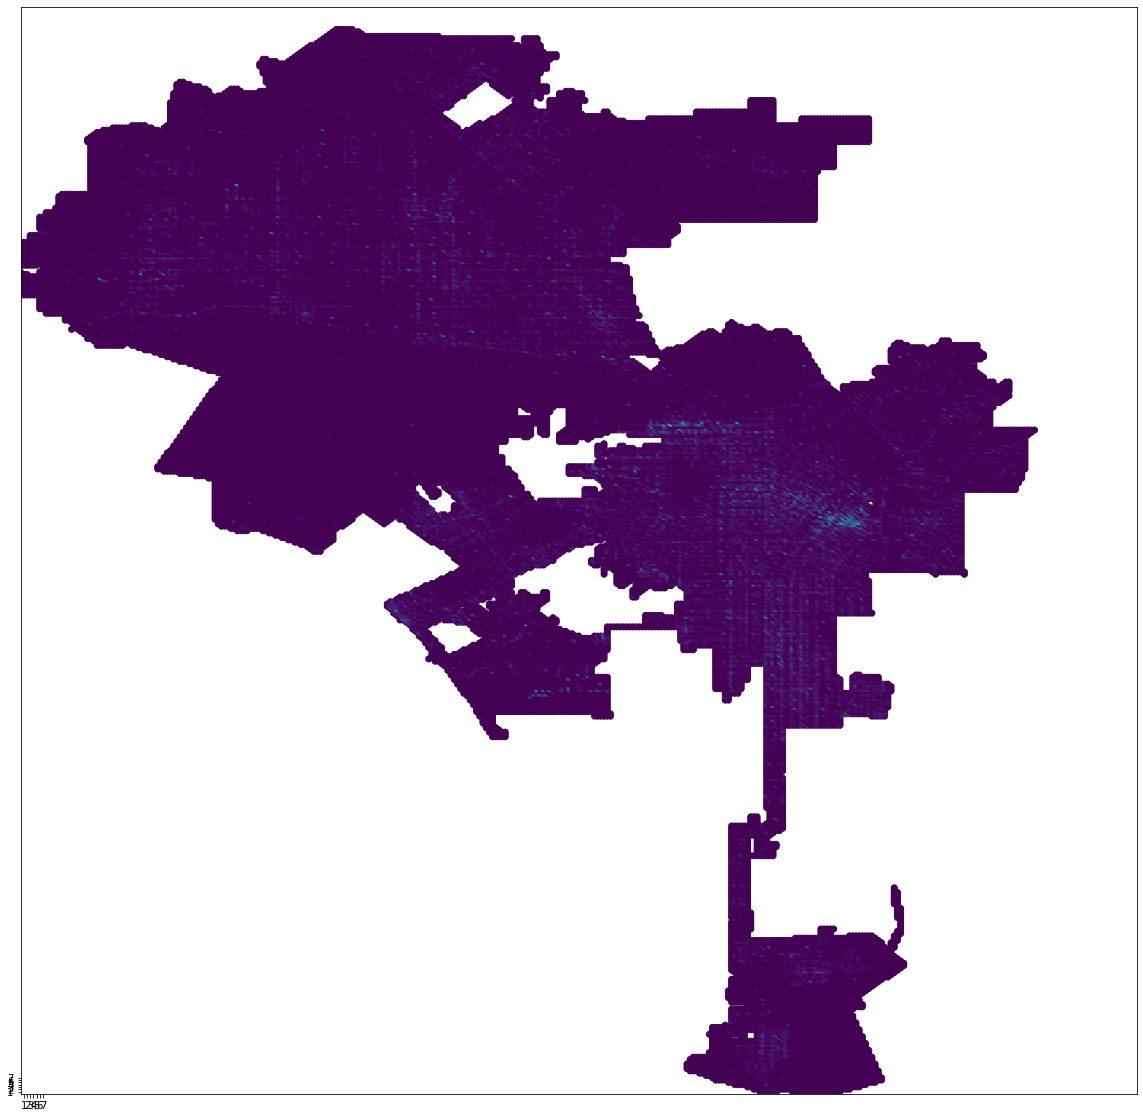

In [ ]:
# make the data
x = []
y = []
arrCnt = []
for key, node in la_graph.nodes.items():
  x.append(key[0])
  y.append(key[1])
  arrCnt.append(0.5*len(node.pd_reports)) # PROPERTY TO VARY HERE

# plot
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.scatter(x, y, c=arrCnt) # can use colormap instea of size&alpha
ax.set(xlim=(0, 350), xticks=np.arange(1, 8),
       ylim=(0, 475), yticks=np.arange(1, 8))

plt.show()


In [ ]:
def patrol(walk_length, graph, start, arrest_rate):
    current_location = start
    path = []
    arrest_data = {node:0 for node in graph.nodes.values()}
    for i in range(walk_length):
        # record location
        path.append(current_location)
        
        # flip a coin to make an arrest
        if random.random() < arrest_rate[current_location]: 
            arrest_data[current_location] += 1
            
        # choose where to go next
        current_location = graph.nodes[random.choice(graph.getNeighbors(current_location))]
    return path, arrest_data

# Patrol Function on LA Dataset

In [ ]:
# In this cell, we run the simulation on the neighborhood
arrest_rate = {node: 0.5 for node in la_graph.nodes.values()}
arrest_concentration = {node:0 for node in la_graph.nodes.values()}
paths = []
for day in range(365):
    start = random.choice(list(la_graph.nodes.values()))
    path, arrest_data = patrol(20, la_graph,start, arrest_rate)
    for key in arrest_concentration:
        arrest_concentration[key] += arrest_data[key]
    paths.append(path)

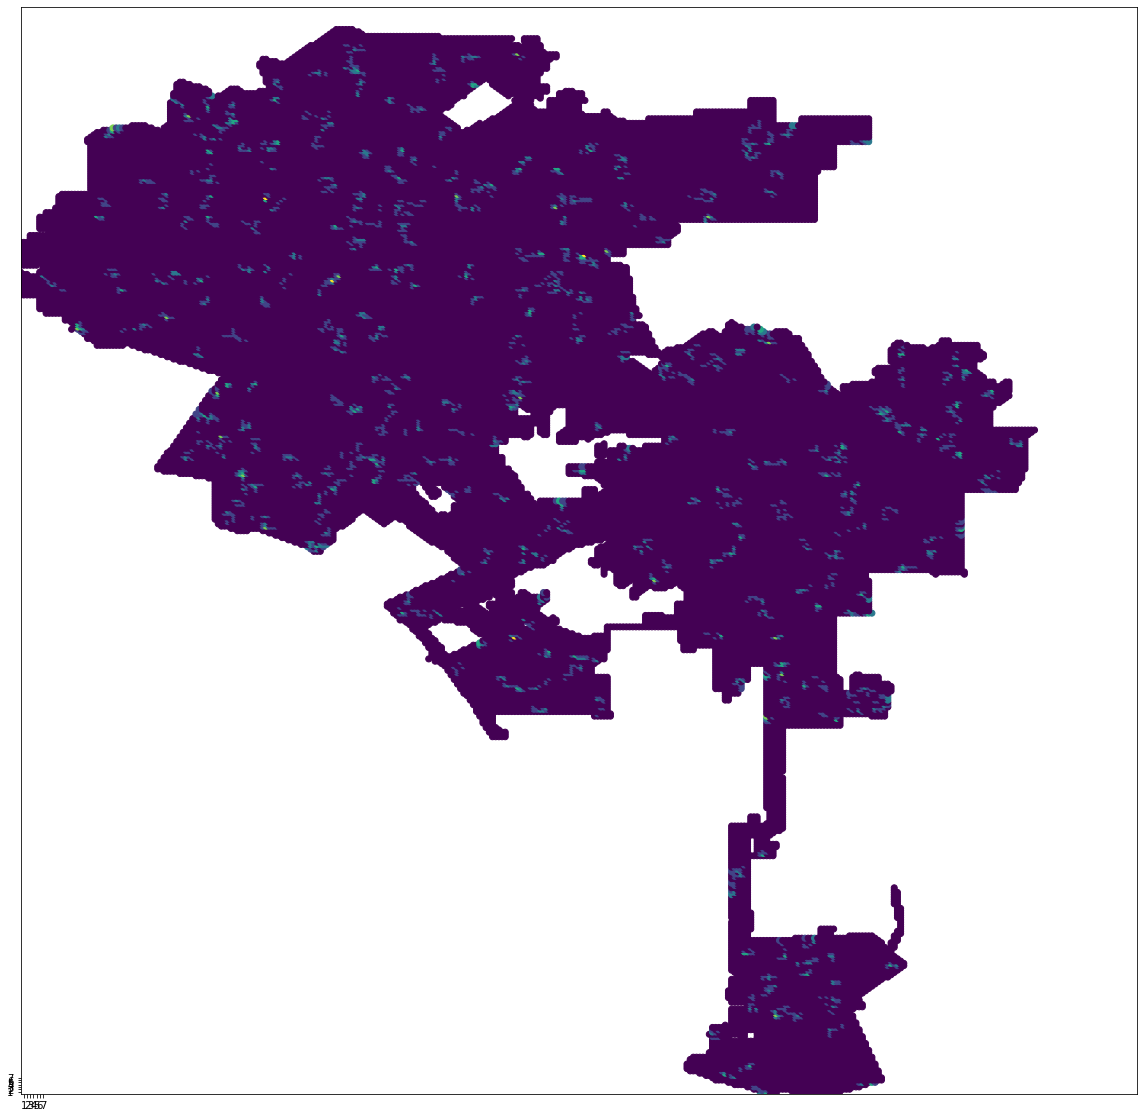

In [ ]:
# make the data
x = []
y = []
arrCnt = []
for key, node in la_graph.nodes.items():
  x.append(key[0])
  y.append(key[1])
  arrCnt.append(arrest_concentration[node]) # PROPERTY TO VARY HERE

# plot
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.scatter(x, y, c=arrCnt) # can use colormap instea of size&alpha
ax.set(xlim=(0, 350), xticks=np.arange(1, 8),
       ylim=(0, 475), yticks=np.arange(1, 8))

plt.show()

## Guided Path Model


**TODO**: return all shortest paths rather than just one. **Note to self:** Factorial space complexity could be a problem. Maybe we should just exponentiate the adjacency matrix to randomly select a path

In [ ]:
"""
Implementation of  Djikstra's algorithm from 
https://en.wikipedia.org/wiki/Dijkstra's_algorithm#Algorithm


TODO: return all shortest paths rather than just one.
"""
def old_traceback(initial, final, graph, distances):
    current = final
    path = [current]
    while current != initial:
        neighbors = [graph.nodes[coords] for coords in graph.getNeighbors(current)]
        neighbors_by_distance = sorted(neighbors, key=lambda node: distances[node])
        current = neighbors_by_distance[0] # get the smallest distance neighbor
        path = [current] + path
    return path

def pseudorandom_traceback(initial,final, graph, distances):
    current = final
    path = [current]
    while current != initial:
        neighbors = [graph.nodes[coords] for coords in graph.getNeighbors(current)]
        nn_dist = min([distances[neighbor] for neighbor in neighbors]) # nearest neighbor distance
        nearest_neighbors = list(filter(lambda n: distances[n] == nn_dist, neighbors))
        current = random.choice(neighbors) # get the smallest distance neighbor
        path = [current] + path
    return path


def get_shortest_paths(initial, final, graph):
    print("entering get_shortest_paths")
    unvisited = {node for node in graph.nodes.values()}
    visited = set()
    distances = {node:0 if node == initial else np.inf  for node in graph.nodes.values()}
    current = initial
    while len(unvisited) > 0 and current != final:
        for neighbor in [graph.nodes[x] for x in graph.getNeighbors(current)]: 
            tentative_distance = distances[current] + 1
            if tentative_distance < distances[neighbor]:
                distances[neighbor] = tentative_distance
        visited.add(current)
        unvisited.remove(current)

        # out of the unvisited nodes, pick the one with
        # the smallest distance to visit next
        min_node = None
        min_distance = np.inf
        for node in unvisited:
            if distances[node] <= min_distance:
                min_node, min_distance = node, distances[node]
        current = min_node
        if min_distance == np.inf:
            # this means no path exists - boo hoo
            break
    if distances[final] == np.inf:
        return "boo hoo - no path possible"
    else:
        # trace back the shortest path from final to initial using distances and adjacency lookups
        # path = old_traceback(initial, final, graph, distances)
        path = pseudorandom_traceback(initial, final, graph, distances)
        # technically, we should return all possible paths, but this is good enough for now.
        print("exiting get_shortest_paths")
        return [path]

In [ ]:
"""
This implementation is subject to change
"""
def select_best_path(paths):
    return random.choice(paths)

In [ ]:
"""
INPUTS:
        - num_trips is a positive integer representing the sample size
        - graph is a Graph object
        - start is a node in the graph
        - arrest_prob is a dictionary mapping the nodes of graph to floats in the range [0,1]
        - destination_probs is a dictionary of dictionaries.
            - destination_probs maps nodes to dictionaries
            - these dictionaries map nodes to floats in the range [0,1]
            - the first node is interpreted as the starting node, 
              the second as the ending node,
              and the float is interpreted as the probability of choosing the ending node given that you
              are currently at the starting node.
OUTPUTS:
        - arrest_data is a dictionary mapping the nodes to number of arrests
          at that node in the simulation
"""
def guided_patrol(num_trips, graph, start, arrest_prob, destination_probs):
    print("entering guided_patrol")
    current_location = start
    arrest_data = {node:0 for node in graph.nodes.values()}
    for i in range(num_trips):
        
        # randomly select a destination
        x = random.random()
        probs = lambda b: destination_probs(current_location, b) # probs is a dictionary mapping nodes to probabilities
        total = 0
        destination = None # initialize destination
        # change this to precincts for better runtime.
        for node in graph.nodes.values():
            total += probs(node) # total represents the cumulative probability of all the prior nodes
            if x < total:
                destination = node
                break

        # walk from current_location to destination
        paths = get_shortest_paths(current_location, destination, graph)
        path = select_best_path(paths)
        for node in path[:-1]: # exclude the destination node
            current_location = node
            if random.random() < arrest_prob[current_location]:
                arrest_data[current_location] += 1
        current_location = destination 
    print("exiting guided patrol")
    return arrest_data

Let's run the simulation on a square grid neighborhood with uniform destination_probs and arrest_prob = 0.5 for each node

In [ ]:
arrest_concentration = {node: 0 for node in la_graph.nodes.values()}
arrest_rate = {node:0.5 for node in la_graph.nodes.values()}
N = len(la_graph.nodes)
# make a uniform destination_probs
destination_probs = lambda a,b: 0 if a == b else 1/(N-1)

paths = []
start = random.choice(list(la_graph.nodes.values()))
for day in range(2):
    arrest_data = guided_patrol(20, la_graph,start, arrest_rate, destination_probs)
    for node in arrest_concentration:
        arrest_concentration[node] += arrest_data[node]

entering guided_patrol
entering get_shortest_paths
exiting get_shortest_paths
entering get_shortest_paths
exiting get_shortest_paths
entering get_shortest_paths
exiting get_shortest_paths
entering get_shortest_paths
exiting get_shortest_paths
entering get_shortest_paths
exiting get_shortest_paths
entering get_shortest_paths


In [ ]:
# In this cell, we plot our results
flip_display = False
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
x, y, z = [], [], []
for node in square_nodes:
    x.append(node[0])
    if flip_display:
        y.append(n-1 - node[1])
    else:
        y.append(node[1])
    z.append(arrest_concentration[node])
bottom = np.zeros_like(z)
width = depth = 1
ax.bar3d(x, y, bottom, width, depth, z, shade=True)
ax.set_title('Simulated Arrests made over a year by location')
plt.show()

## Memory Weighting Model

In this model, we weight the probability of visiting a node by the number of arrests recorded at each node. For ease of implementation, the odds of a node which has been visited *n* times being visited versus one which has been visited *m* times are *n+1:m+1*. Everything Else is the same as the guided path model

In [ ]:
"""
INPUTS:
        - num_trips is a positive integer representing the sample size
        - graph is a Graph object
        - start is a node in the graph
        - arrest_prob is a dictionary mapping the nodes of graph to floats in the range [0,1]
        - destination_probs is a dictionary of dictionaries.
            - destination_probs maps nodes to dictionaries
            - these dictionaries map nodes to floats in the range [0,1]
            - the first node is interpreted as the starting node, 
              the second as the ending node,
              and the float is interpreted as the probability of choosing the ending node given that you
              are currently at the starting node.
OUTPUTS:
        - arrest_data is a dictionary mapping the nodes to number of arrests
          at that node in the simulation
"""
def weighted_patrol(num_trips, graph, start, arrest_prob):

    current_location = start
    arrests = {node:0 for node in graph.nodes}
    visits = {node:0 for node in graph.nodes}
    total_weight = sum([arrests[node] for node in graph.nodes]) + len(graph.nodes)
    for i in range(num_trips):
        
        # randomly select a destination
        x = random.random()
        probs = {node:(arrests[node]+1)/total_weight for node in graph.nodes} # probs is a dictionary mapping nodes to probabilities
        total = 0
        destination = None # initialize destination
        for key in probs:
            total += probs[key] # total represents the cumulative probability of all the prior nodes
            if x < total:
                destination = key
                visits[destination] += 1
                break

        # walk from current_location to destination
        paths = get_shortest_paths(current_location, destination, graph)
        path = select_best_path(paths)
        for node in path[:-1]: # exclude the destination node
            current_location = node
            if random.random() < arrest_prob[current_location]:
                arrests[current_location] += 1
                total_weight += 1
        current_location = destination 
    return arrests

In [ ]:
N = len(square_nodes)
arrest_concentration = {node: 0 for node in square_nodes}

# make a uniform destination_probs
destination_probs = {}
for start_node in square_nodes:
    visit_probability = {}
    for end_node in square_nodes:
        visit_probability[end_node] = 0 if end_node == start_node else 1/(N-1)
    destination_probs[start_node] = visit_probability

paths = []
for day in range(365):
    arrest_data = weighted_patrol(20, G_square,(0,0), arrest_rate_square2)
    for node in arrest_concentration:
        arrest_concentration[node] += arrest_data[node]

In [ ]:
# In this cell, we plot our results
flip_display = False
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
x, y, z = [], [], []
for node in square_nodes:
    x.append(node[0])
    if flip_display:
        y.append(n-1 - node[1])
    else:
        y.append(node[1])
    z.append(arrest_concentration[node])
bottom = np.zeros_like(z)
width = depth = 1
ax.bar3d(x, y, bottom, width, depth, z, shade=True)
ax.set_title('Simulated Arrests made over a year by location')
plt.show()

What are the important parameters of the model?

**1. The patrolling algorithm (# visits)**

**2. The arrest probabilities (# arrests/visit)**

Although there can be some interesting dynamics between these two, it seems that in our current models, they don't really affect each other.

# LA graph patrol
Small changes to ```patrol()``` to make compatible with LA_graph scheme

In [ ]:
def la_patrol(walk_length, graph, start, arrest_rate):
    current_location = start
    path = []
    arrest_data = {node:0 for node in graph.nodes.keys()}
    for i in range(walk_length):
        # record location
        path.append(current_location)
        
        # flip a coin to make an arrest
        if random.random() < arrest_rate[current_location.ID]: 
            arrest_data[current_location.ID] = arrest_data.setdefault(current_location.ID, 0) + 1
            
        # choose where to go next
        next_ind = random.choice(graph.getNeighbors(current_location))
        current_location = graph.nodes[next_ind]
        # current_location = random.choice(graph.getNeighbors(current_location))
    return path, arrest_data

# Testing for LA_patrol

In [ ]:
arrest_rate_la = {node.ID : 0.5 for node in la_graph.nodes.values()}
start_cel = random.choice(list(la_graph.nodes.values()))
print(type(start_cel))
print(start_cel.ID)
# run the simulation on the neighborhood

arrest_concentration_la = {node.ID: 0 for node in la_graph.nodes.values()}

paths = []
for start_loc in range(25):
  start_cel = random.choice(list(la_graph.nodes.values()))
  for day in range(365):
    path, arrest_data = la_patrol(10000, la_graph, start_cel, arrest_rate_la) #
    for nodeID in arrest_concentration_la.keys():
        arrest_concentration_la[nodeID] += arrest_data[nodeID]
    paths.append(path)

In [ ]:
# make the data
x = []
y = []
arrCnt = []
for id, count in arrest_concentration_la.items():
  x.append(id[0])
  y.append(id[1])
  arrCnt.append(count) # PROPERTY TO VARY HERE

# plot
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.scatter(x, y, s=.75, c=arrCnt, cmap = cm.get_cmap('plasma')) # can use colormap instea of size&alpha
ax.set(xlim=(0, 350), xticks=np.arange(1, 8),
       ylim=(0, 475), yticks=np.arange(1, 8))

plt.show()